# Load data

In [121]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [122]:
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from datetime import datetime

from sklearn.metrics import mean_squared_error as mse 
from sklearn.metrics import mean_absolute_error as mae

import os
import sys
from pathlib import Path

PROJ_ROOT = Path(os.getcwd()).parent.parent
sys.path.append(str(PROJ_ROOT))  # add project root file to the python paths
data_path = PROJ_ROOT / "data"

from vol_predict.backtest.benchmark_backtester import BenchmarkBacktester
from vol_predict.models.baselines.benchmarks import Naive, EWMA, ARIMAX, GARCH, HAR# , STS
from vol_predict.models.baselines.benchmarks import ENET, RF, XGBM

sns.set(style="whitegrid")
#sns.set_style("darkgrid")
plt.rc("figure", figsize=(16, 6))
plt.rc("savefig", dpi=90)
plt.rc("font", family="sans-serif")
plt.rc("font", size=14)

In [123]:
full_data = (
    pl.read_csv(data_path / "btc" / "data_df.csv")
    .with_columns(pl.col("datetime").str.to_datetime("%Y-%m-%d %H:%M:%S"))
    .sort("datetime")
    ).to_pandas().set_index("datetime")

In [124]:
# make lagged volatility variables, 4 of them

for i in range(1, 5):
    full_data[f"vol_lag{i}"] = full_data["vol"].shift(i)

# add log volatilities
full_data["log_vol"] = np.log(full_data["vol"])
for i in range(1, 5):
    full_data[f"log_vol_lag{i}"] = full_data["log_vol"].shift(i)

ob_features = [
    "spread", 
    # "ask_depth", 
    "bid_depth", 
    # "depth_diff", 
    "ask_volume", 
    "bid_volume", 
    "volume_diff", 
    "weighted_spread", 
    "ask_slope", 
    "bid_slope"
]
for col in ob_features:
    full_data[f'mean_{col}'] = full_data.loc[:, full_data.columns.str.startswith(col)].mean(axis=1)

    # full_data[f'trend_{col}'] = full_data.loc[:, full_data.columns.str.startswith(col)].apply(
    #     lambda x: np.polyfit(range(len(x)), x, 1)[0], axis=1
    # )
dataset = full_data.dropna().loc[:, 
                          ['vol', 'ret', 'log_vol'] +
                          [f'vol_lag{i}' for i in range(1,5)] +
                          [f'log_vol_lag{i}' for i in range(1,5)] +
                          [f'mean_{col}' for col in ob_features] #+ 
                          #[f'trend_{col}' for col in ob_features]
                          ]

In [125]:
dataset.columns 

Index(['vol', 'ret', 'log_vol', 'vol_lag1', 'vol_lag2', 'vol_lag3', 'vol_lag4',
       'log_vol_lag1', 'log_vol_lag2', 'log_vol_lag3', 'log_vol_lag4',
       'mean_spread', 'mean_bid_depth', 'mean_ask_volume', 'mean_bid_volume',
       'mean_volume_diff', 'mean_weighted_spread', 'mean_ask_slope',
       'mean_bid_slope'],
      dtype='object')

In [126]:
IS_EXPANDING = False
suffix = "expanding" if IS_EXPANDING else "rolling"
LOOK_BACK = pd.Timedelta(days=30)

In [127]:
LAST_TRAINING_DATE = datetime.strptime("2018-06-30 23:59:59", "%Y-%m-%d %H:%M:%S")
init_training_vola = dataset.loc[:LAST_TRAINING_DATE]

In [128]:
backtester = BenchmarkBacktester(
    dataset=dataset,
    last_train_date=LAST_TRAINING_DATE,
    is_training_expanded=IS_EXPANDING,
    lookback=LOOK_BACK,
)

# Backtesting Univariate models

## Naive

100%|██████████| 1957/1957 [00:03<00:00, 613.66it/s]


Backtest finished successfully.
---------------------------------------------------
Model: Naive
RMSE: 0.0002827
MAE:  0.0000921
Weekly RMSE: 0.0002729 +/- 0.0000811
Weekly MAE:  0.0000965 +/- 0.0000168
Expanding training set: False
Forecast horizon: 1
Test starting date: 2018-06-30 23:59:59
---------------------------------------------------


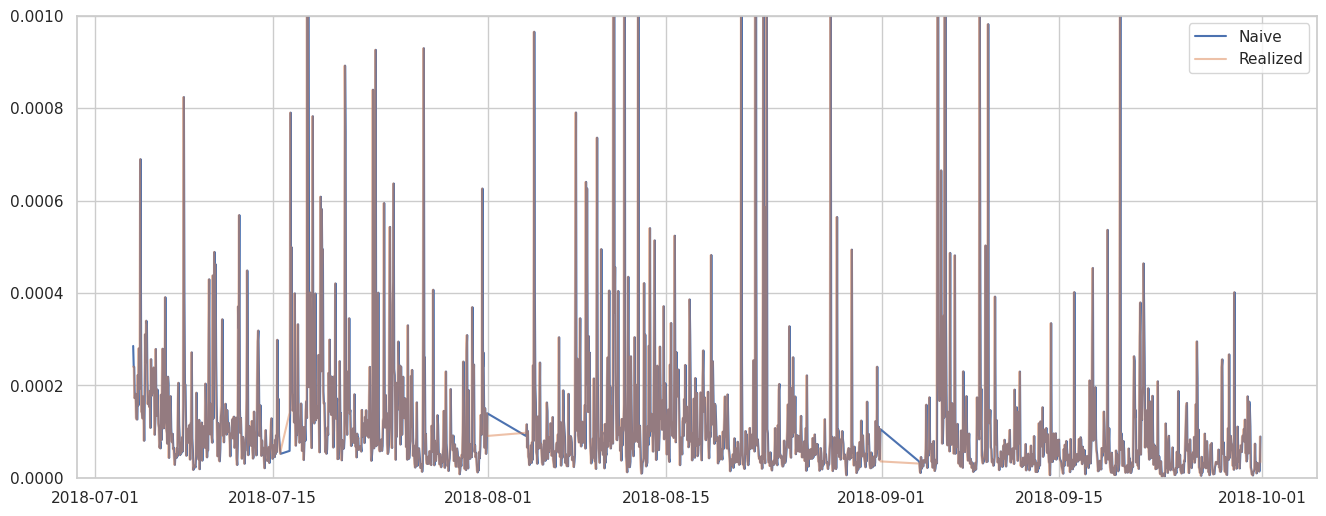

In [92]:
backtest_results_naive = backtester.backtest(Naive)

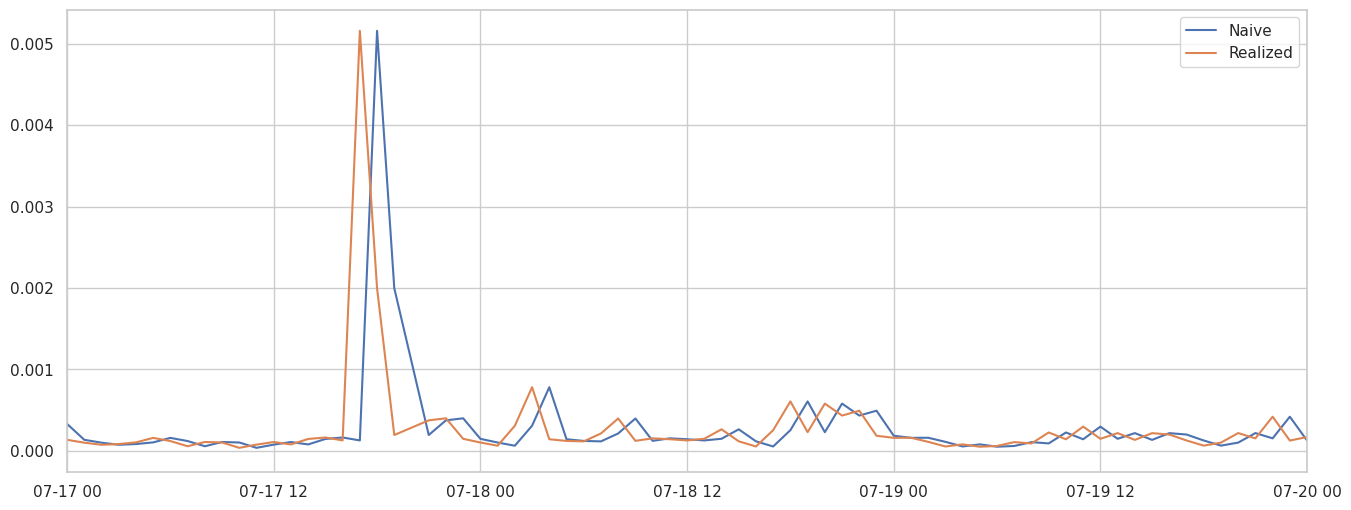

In [93]:
plt.plot(backtest_results_naive.forecasts, label="Naive")
plt.plot(backtest_results_naive.true_vola, label="Realized")
plt.xlim(
    datetime.strptime("2018-07-17 00:00:00", "%Y-%m-%d %H:%M:%S"),
    datetime.strptime("2018-07-20 00:00:00", "%Y-%m-%d %H:%M:%S"),
)
plt.legend()


In [94]:
backtest_results_naive.forecasts.to_csv(
    data_path / "output" / "benchmark_backtest" / f"naive_{suffix}.csv",
    index=True,
)

## EWMA

100%|██████████| 1957/1957 [00:03<00:00, 620.69it/s]


Backtest finished successfully.
---------------------------------------------------
Model: EWMA
RMSE: 0.0002475
MAE:  0.0000927
Weekly RMSE: 0.0002396 +/- 0.0000671
Weekly MAE:  0.0000961 +/- 0.0000157
Expanding training set: False
Forecast horizon: 1
Test starting date: 2018-06-30 23:59:59
---------------------------------------------------


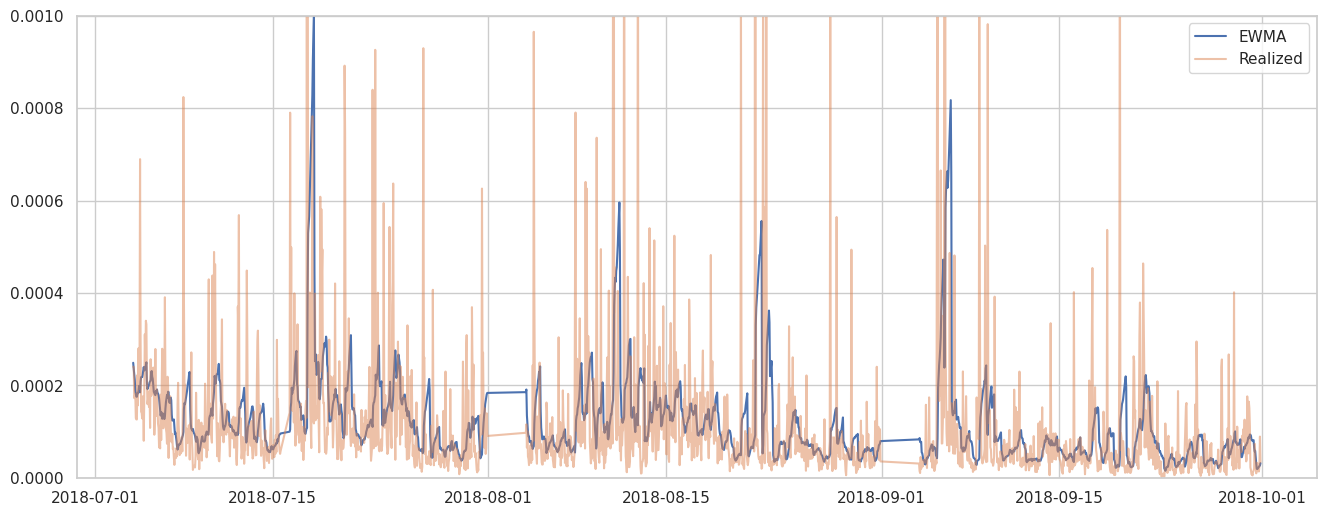

In [95]:
backtest_results_ewma = backtester.backtest(EWMA, hyperparams={"look_back": 12, "half_life": 12})

In [96]:
backtest_results_ewma.forecasts.to_csv(
    data_path / "output" / "benchmark_backtest" / f"ewma_{suffix}.csv",
    index=True,
)

<Axes: xlabel='datetime'>

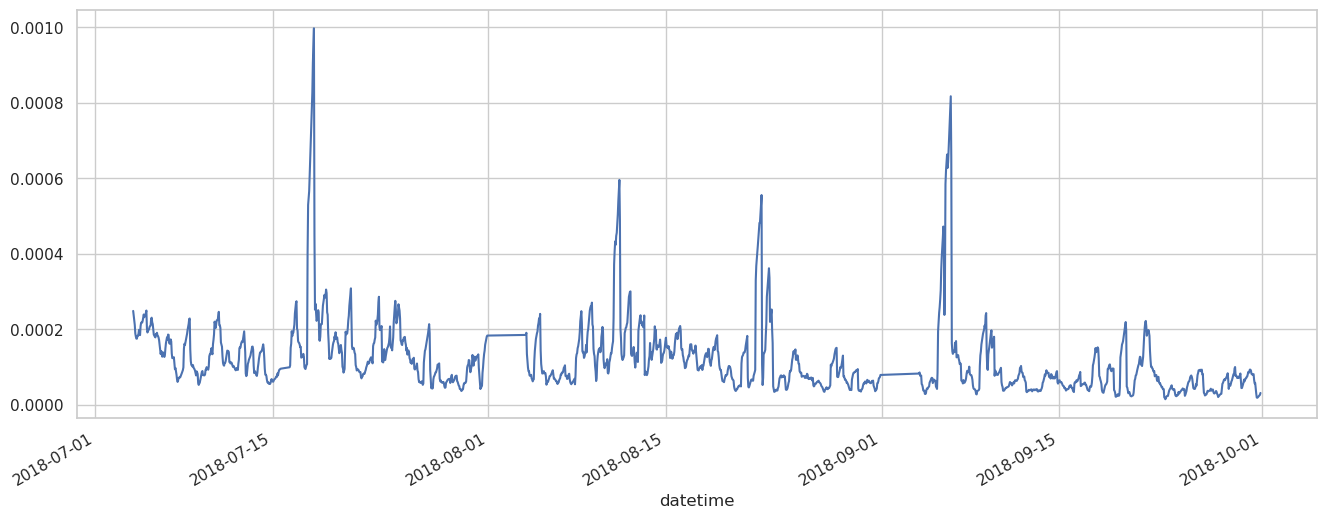

In [97]:
backtest_results_ewma.forecasts.plot(label="EWMA")

## ARIMA

/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  0%|          | 0/1957 [00:00<?, ?it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  7%|▋         | 142/1957 [00:03<00:32, 55.21it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 23%|██▎       | 454/1957 [00:09<00:23, 62.88it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Max

Backtest finished successfully.
---------------------------------------------------
Model: ARIMAX
RMSE: 0.0002316
MAE:  0.0000923
Weekly RMSE: 0.0002247 +/- 0.0000626
Weekly MAE:  0.0000957 +/- 0.0000115
Expanding training set: False
Forecast horizon: 1
Test starting date: 2018-06-30 23:59:59
---------------------------------------------------


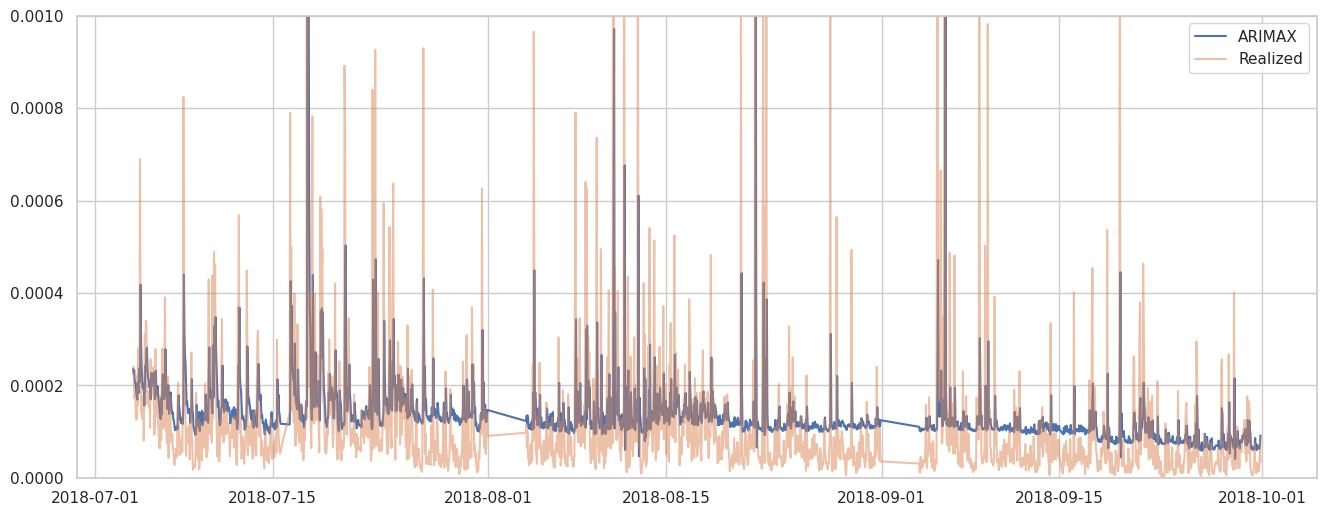

In [129]:
backtest_results_arima = backtester.backtest(ARIMAX, hyperparams={"p": 1, "d": 0, "q": 2}, is_multivariate=False)

In [130]:
backtest_results_arima.forecasts.to_csv(
    data_path / "output" / "benchmark_backtest" / f"arima_{suffix}.csv",
    index=True,
)

## GARCH

/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.706e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
  0%|          | 0/1957 [00:00<?, ?it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.701e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warning

Backtest finished successfully.
---------------------------------------------------
Model: GARCH
RMSE: 0.1676253
MAE:  0.0372087
Weekly RMSE: 0.0977101 +/- 0.1439833
Weekly MAE:  0.0378156 +/- 0.0557073
Expanding training set: False
Forecast horizon: 1
Test starting date: 2018-06-30 23:59:59
---------------------------------------------------


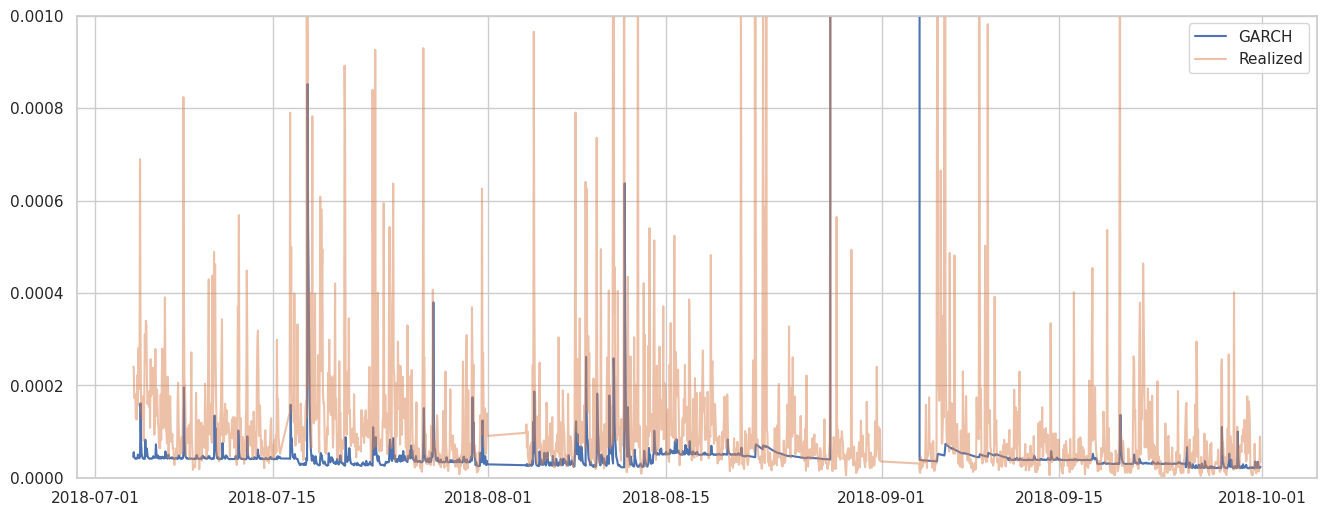

In [100]:
backtest_results_garch = backtester.backtest(GARCH, 
    hyperparams={"p": 1, "o": 0, "q": 1, 'dist': "normal"},
    is_multivariate=False)

In [101]:
backtest_results_garch.forecasts.to_csv(
    data_path / "output" / "benchmark_backtest" / f"garch_{suffix}.csv",
    index=True,
)

### t-EGARCH

/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.706e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
  0%|          | 0/1957 [00:00<?, ?it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.701e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warning

Backtest finished successfully.
---------------------------------------------------
Model: GARCH
RMSE: 193.4088341
MAE:  4.3836251
Weekly RMSE: 84.5086110 +/- 152.8793974
Weekly MAE:  3.3476383 +/- 6.0558011
Expanding training set: False
Forecast horizon: 1
Test starting date: 2018-06-30 23:59:59
---------------------------------------------------


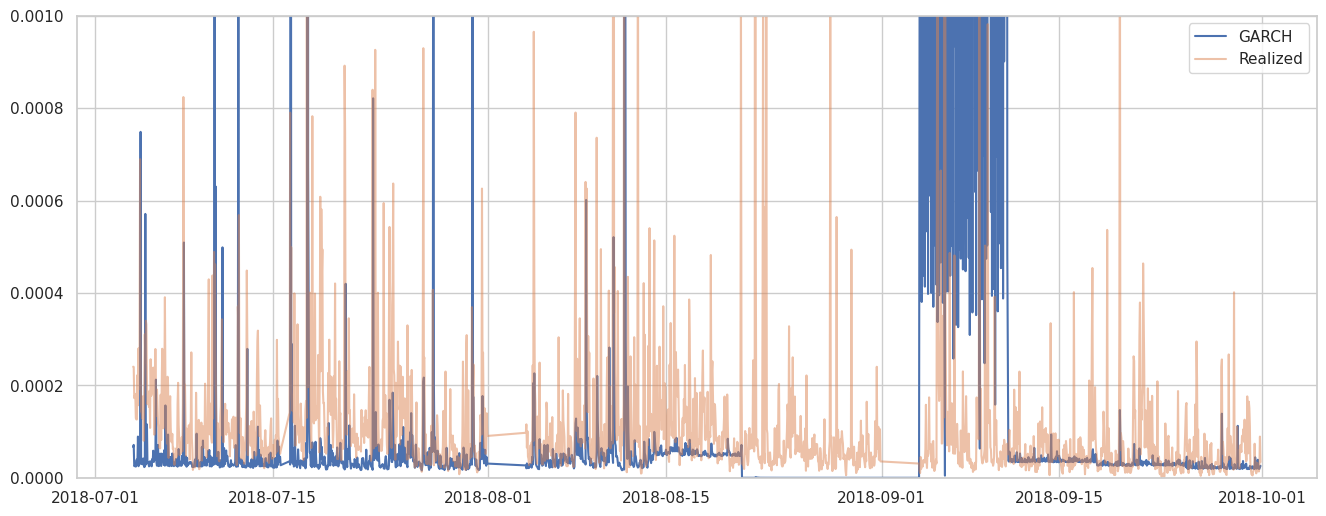

In [102]:
backtest_results_egarch = backtester.backtest(GARCH, 
    hyperparams={"p": 1, "o": 0, "q": 1, 'dist': "normal", 'type': "EGARCH"},
    is_multivariate=False)

In [103]:
backtest_results_egarch.forecasts.to_csv(
    data_path / "output" / "benchmark_backtest" / f"egarch_{suffix}.csv",
    index=True,
)

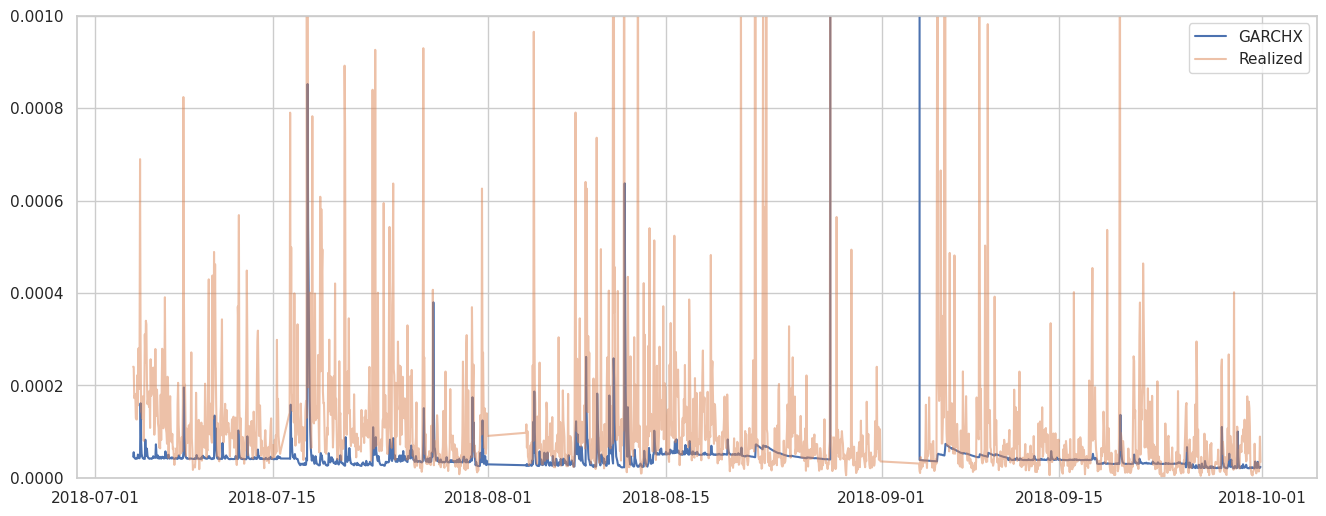

In [104]:
plt.plot(backtest_results_garch.forecasts, label="GARCHX")
plt.plot(backtest_results_garch.true_vola, label="Realized", alpha=0.5)
plt.ylim(0, 0.001)
plt.legend()

Using t-distribution (skewed or not) leads to convergence issues, even in the expanding window. 

## HAR

In [105]:
from arch.univariate.distribution import (
    Distribution,
    GeneralizedError,
    Normal,
    SkewStudent,
    StudentsT,
)


/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 3.223e-08. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 1e+04 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
  0%|          | 0/1957 [00:00<?, ?it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 3.219e-08. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 1e+04 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  war

Backtest finished successfully.
---------------------------------------------------
Model: HAR
RMSE: 0.0002295
MAE:  0.0000890
Weekly RMSE: 0.0002224 +/- 0.0000623
Weekly MAE:  0.0000923 +/- 0.0000116
Expanding training set: False
Forecast horizon: 1
Test starting date: 2018-06-30 23:59:59
---------------------------------------------------


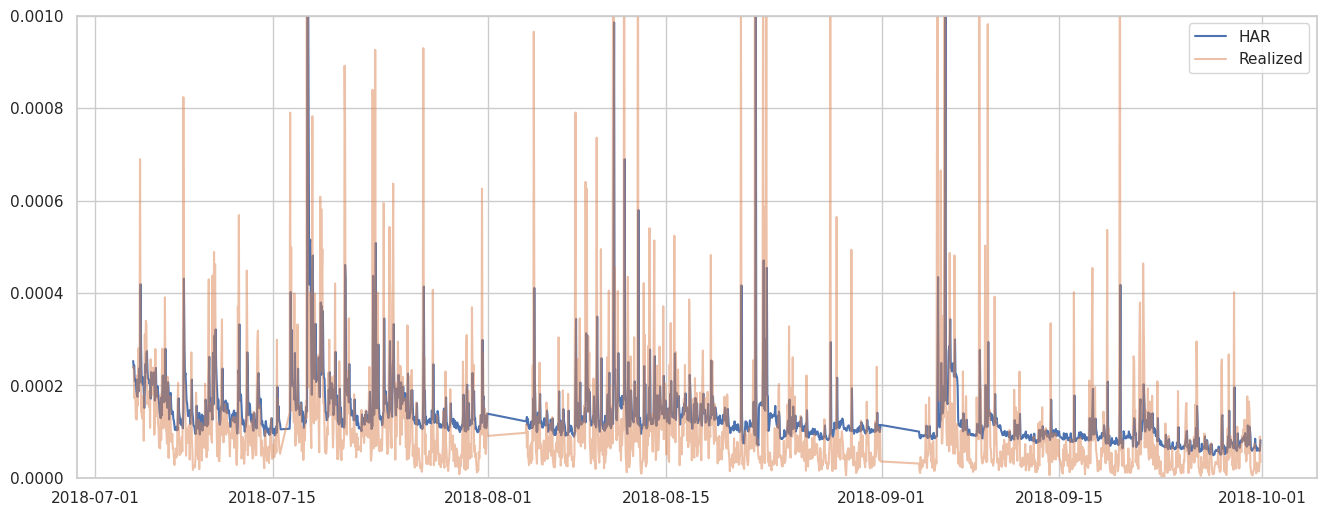

In [106]:
backtest_results_har = backtester.backtest(HAR, 
    hyperparams={'lags':[1, 6, 24], 'distribution': Normal()},
    is_multivariate=False)

In [107]:
backtest_results_har.forecasts.to_csv(
    data_path / "output" / "benchmark_backtest" / f"har_{suffix}.csv",
    index=True,
)

# Backtesting Multivariate models

## ARIMAX

/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  0%|          | 0/1957 [00:00<?, ?it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  7%|▋         | 138/1957 [00:02<00:35, 51.27it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 15%|█▍        | 290/1957 [00:07<00:39, 42.68it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Max

Backtest finished successfully.
---------------------------------------------------
Model: ARIMAX
RMSE: 0.0002352
MAE:  0.0000952
Weekly RMSE: 0.0002279 +/- 0.0000630
Weekly MAE:  0.0000976 +/- 0.0000182
Expanding training set: False
Forecast horizon: 1
Test starting date: 2018-06-30 23:59:59
---------------------------------------------------


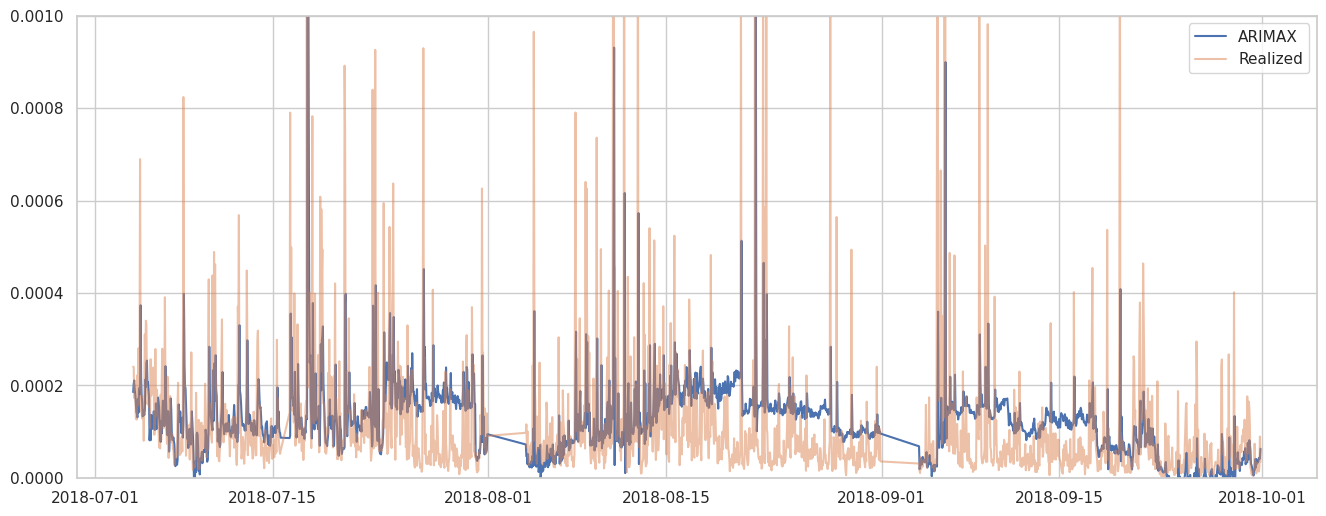

In [131]:
backtest_results_arimax = backtester.backtest(ARIMAX, 
                                             hyperparams={"p": 1, "d": 0, "q": 2}, 
                                             is_multivariate=True)

In [132]:
backtest_results_arimax.forecasts.to_csv(
    data_path / "output" / "benchmark_backtest" / f"arimax_{suffix}.csv",
    index=True,
)

## GARCHX

/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.706e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
  0%|          | 0/1957 [00:00<?, ?it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.701e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warning

Backtest finished successfully.
---------------------------------------------------
Model: GARCH
RMSE: 0.1676253
MAE:  0.0372087
Weekly RMSE: 0.0977101 +/- 0.1439833
Weekly MAE:  0.0378156 +/- 0.0557073
Expanding training set: False
Forecast horizon: 1
Test starting date: 2018-06-30 23:59:59
---------------------------------------------------


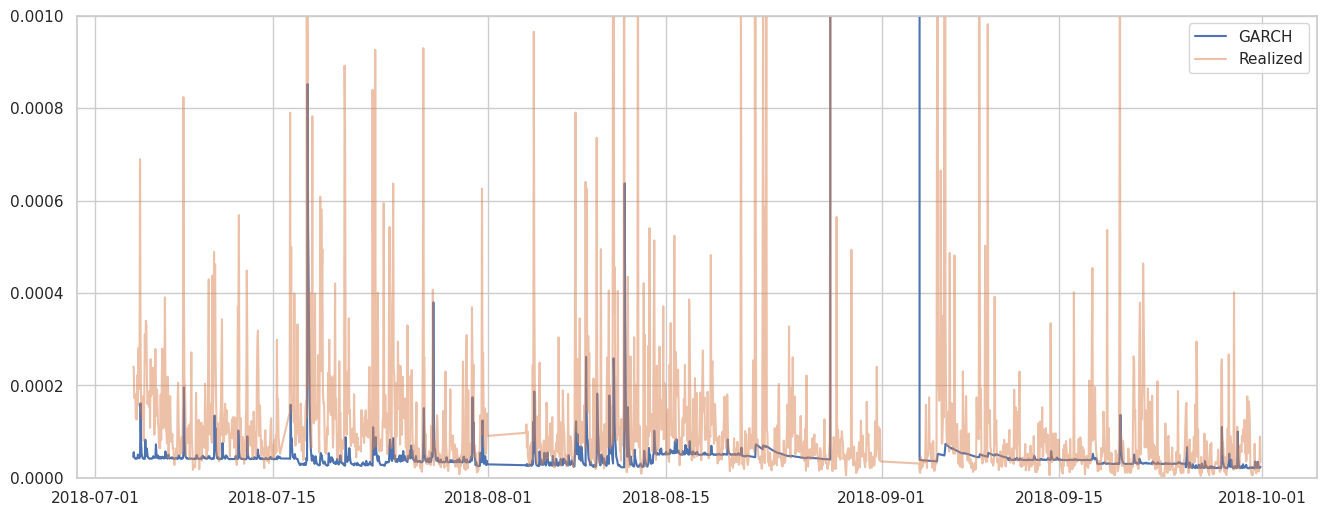

In [110]:
backtest_results_garchx = backtester.backtest(GARCH, 
    hyperparams={"p": 1, "o": 0, "q": 1, 'dist': "normal"},
    is_multivariate=True)

In [111]:
backtest_results_garchx.forecasts.to_csv(
    data_path / "output" / "benchmark_backtest" / f"garchx_{suffix}.csv",
    index=True,
)

## HARX

/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 3.187e-08. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 1e+04 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
  0%|          | 0/1957 [00:00<?, ?it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 3.184e-08. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 1e+04 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  war

Backtest finished successfully.
---------------------------------------------------
Model: HAR
RMSE: 0.0002328
MAE:  0.0000912
Weekly RMSE: 0.0002254 +/- 0.0000638
Weekly MAE:  0.0000948 +/- 0.0000191
Expanding training set: False
Forecast horizon: 1
Test starting date: 2018-06-30 23:59:59
---------------------------------------------------


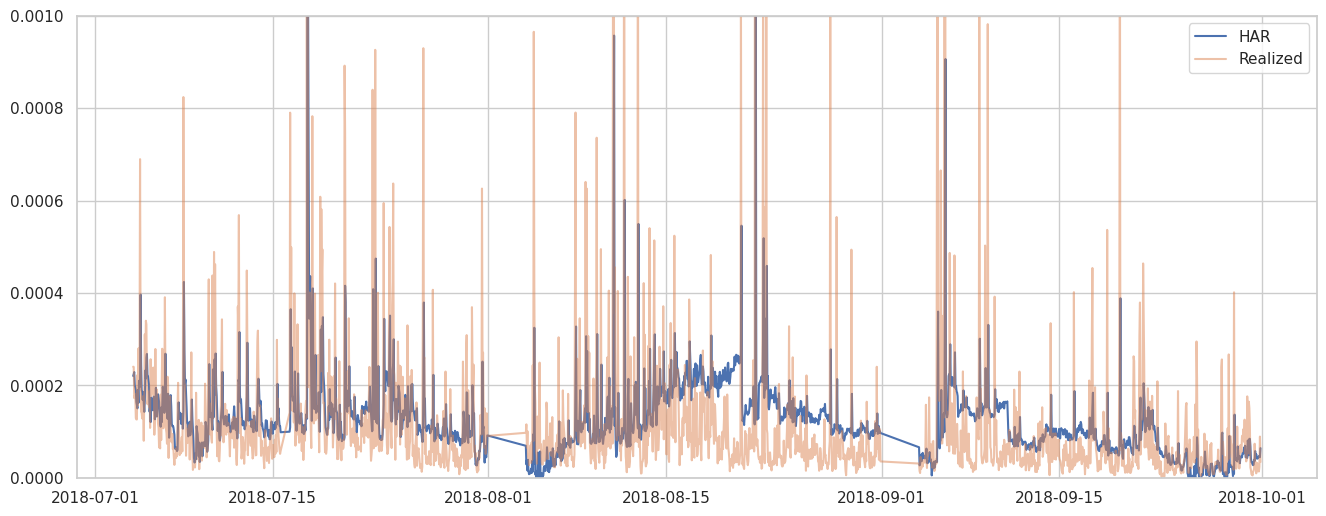

In [112]:
backtest_results_harx = backtester.backtest(HAR, 
    hyperparams={'lags':[1, 6, 24], 'distribution': Normal()},
    is_multivariate=True)

In [113]:
backtest_results_harx.forecasts.to_csv(
    data_path / "output" / "benchmark_backtest" / f"harx_{suffix}.csv",
    index=True,
)

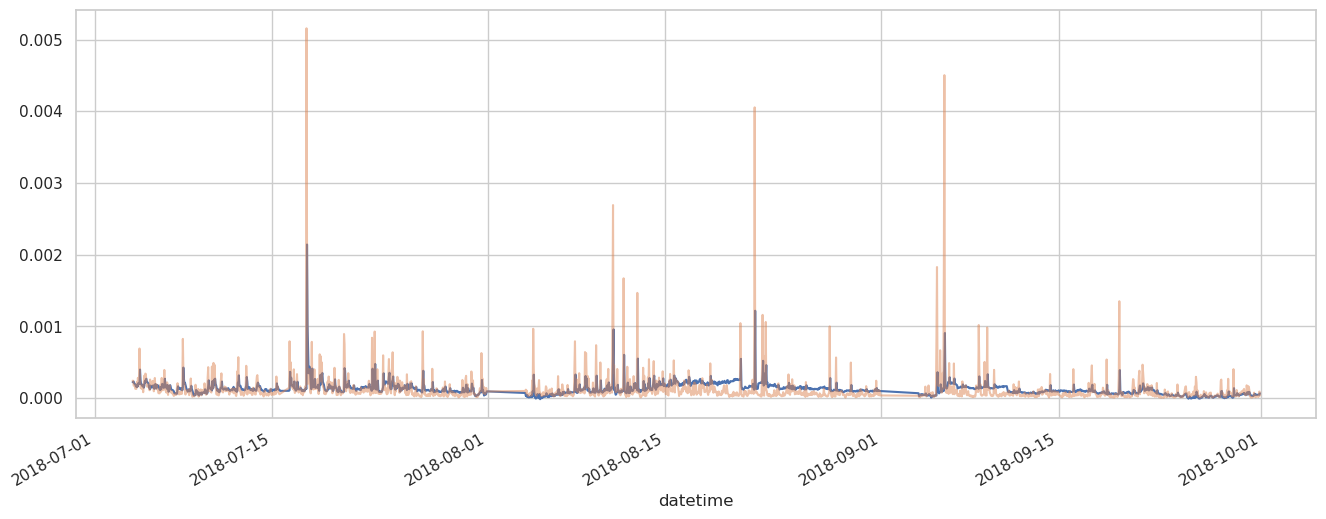

In [114]:
backtest_results_harx.forecasts.plot(label="HARX")
plt.plot(backtest_results_harx.true_vola, label="Realized", alpha=0.5)

## Elastic Net

100%|██████████| 1957/1957 [00:03<00:00, 534.28it/s]


Backtest finished successfully.
---------------------------------------------------
Model: ENET
RMSE: 0.0002440
MAE:  0.0001031
Weekly RMSE: 0.0002366 +/- 0.0000648
Weekly MAE:  0.0001058 +/- 0.0000144
Expanding training set: False
Forecast horizon: 1
Test starting date: 2018-06-30 23:59:59
---------------------------------------------------


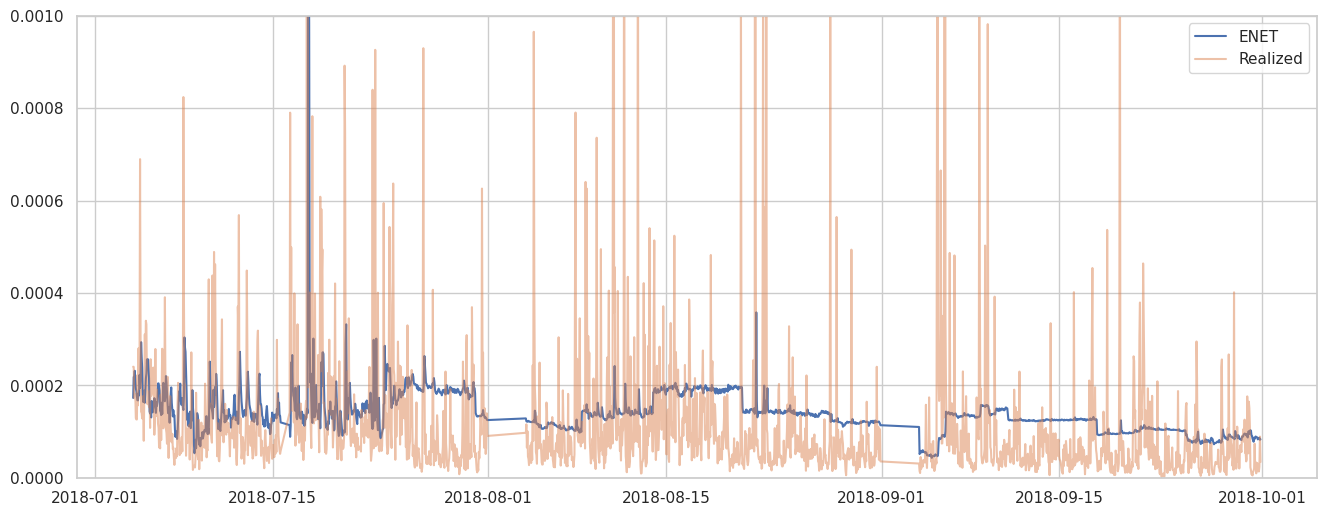

In [115]:
backtest_results_enet = backtester.backtest(ENET, 
    hyperparams={'alpha':1e-5, 'l1_ratio': 0.7},
    is_multivariate=True)

In [116]:
backtest_results_enet.forecasts.to_csv(
    data_path / "output" / "benchmark_backtest" / f"enet_{suffix}.csv",
    index=True,
)

## Random Forest

100%|██████████| 1957/1957 [00:30<00:00, 63.22it/s] 


Backtest finished successfully.
---------------------------------------------------
Model: RF
RMSE: 0.0002880
MAE:  0.0001382
Weekly RMSE: 0.0002836 +/- 0.0000761
Weekly MAE:  0.0001475 +/- 0.0000494
Expanding training set: False
Forecast horizon: 1
Test starting date: 2018-06-30 23:59:59
---------------------------------------------------


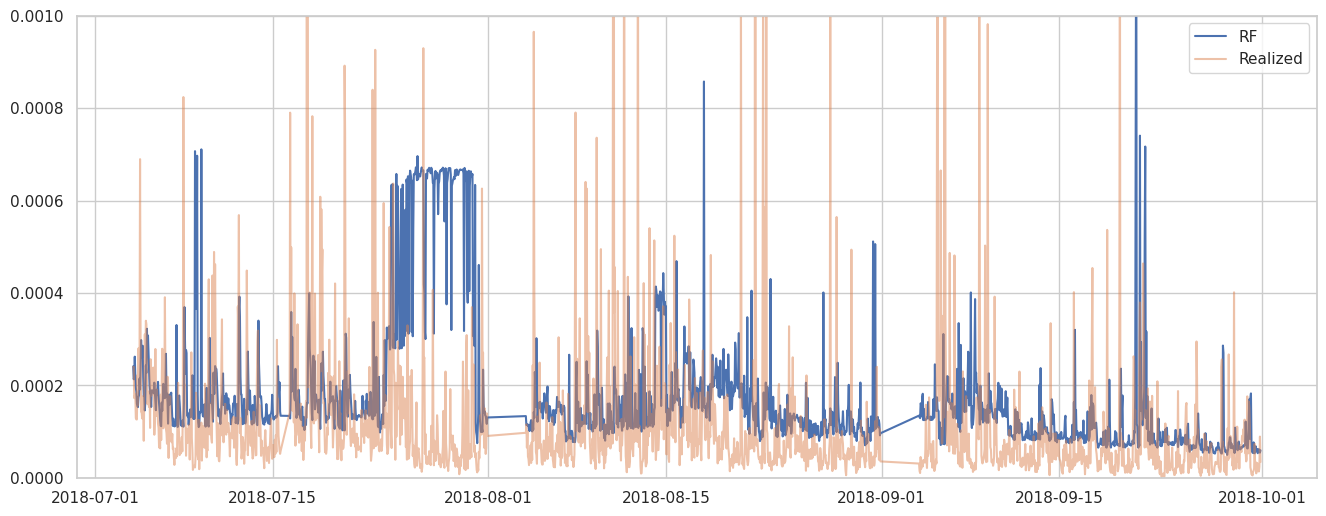

In [117]:
backtest_results_rf = backtester.backtest(RF, 
    hyperparams={'n_estimators':200, 'max_depth': 5, 'min_samples_split': 10},
    is_multivariate=True)

In [118]:
backtest_results_rf.forecasts.to_csv(
    data_path / "output" / "benchmark_backtest" / f"rf_{suffix}.csv",
    index=True,
)

## XGBM

/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:45:51] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1747336936436/work/src/learner.cc:738: 
Parameters: { "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
  0%|          | 0/1957 [00:00<?, ?it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:45:52] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1747336936436/work/src/learner.cc:738: 
Parameters: { "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
  7%|▋         | 138/1957 [00:00<00:13, 130.09it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:45:53] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1747336936436/work/src/learner.cc:738: 
Parameters: { "min_samples_split" } are not used.

  bst.up

Backtest finished successfully.
---------------------------------------------------
Model: XGBM
RMSE: 0.0002416
MAE:  0.0001057
Weekly RMSE: 0.0002371 +/- 0.0000568
Weekly MAE:  0.0001126 +/- 0.0000086
Expanding training set: False
Forecast horizon: 1
Test starting date: 2018-06-30 23:59:59
---------------------------------------------------


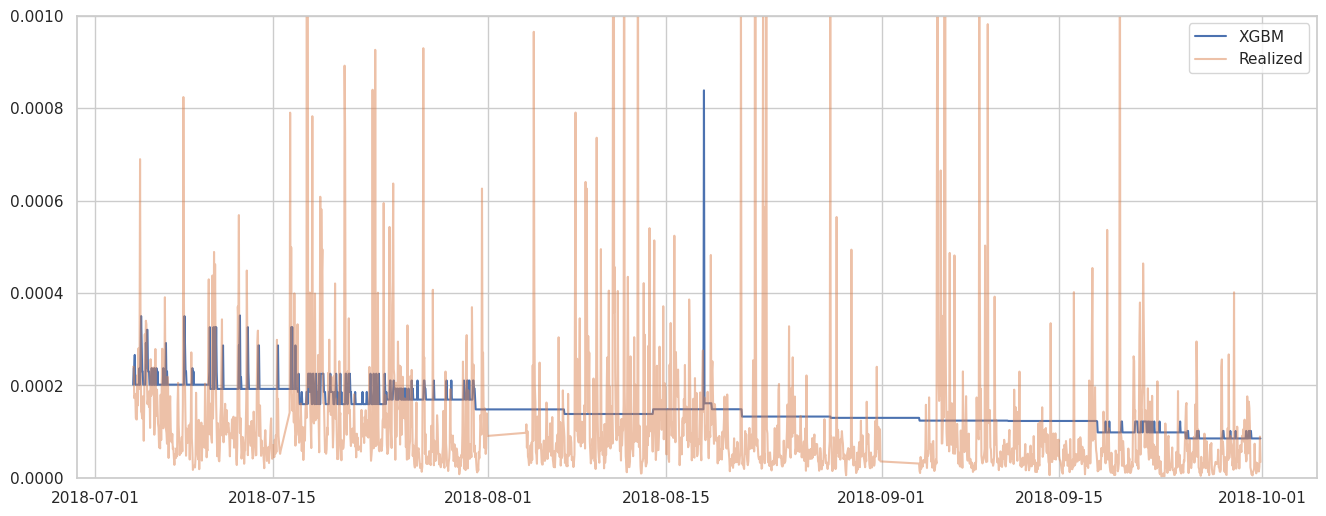

In [119]:
backtest_results_xgbm = backtester.backtest(XGBM, 
    hyperparams={'n_estimators':200, 'max_depth': 5, 'min_samples_split': 20},
    is_multivariate=True)

In [120]:
backtest_results_xgbm.forecasts.to_csv(
    data_path / "output" / "benchmark_backtest" / f"xgbm_{suffix}.csv",
    index=True,
)